# Determining missing uncertainties on volume, lenght and heigth

In the notebook 01_clean_esec, we saw that not all events have associated uncertainties. Here, we will fill in the missing uncertainties in volume, length and height of avalanches.

This code was written by Antoine Lucas (<lucas@ipgp.fr>) and Thibaut Céci (<thi.ceci@gmail.com>).

## We will compute the uncertainties in 4 steps :
1. Remove outliers in volume, length and height to be able to build models without disturbance
2. Plot a fitted model in volume, length and height
3. Compute confidence intervals
4. Plot confidence intervals in volume, length and height and compute uncertainties

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import catalog
import computations as cp
import figures

catalog.display_parameters()

## Load ESEC with the 88 avalanches

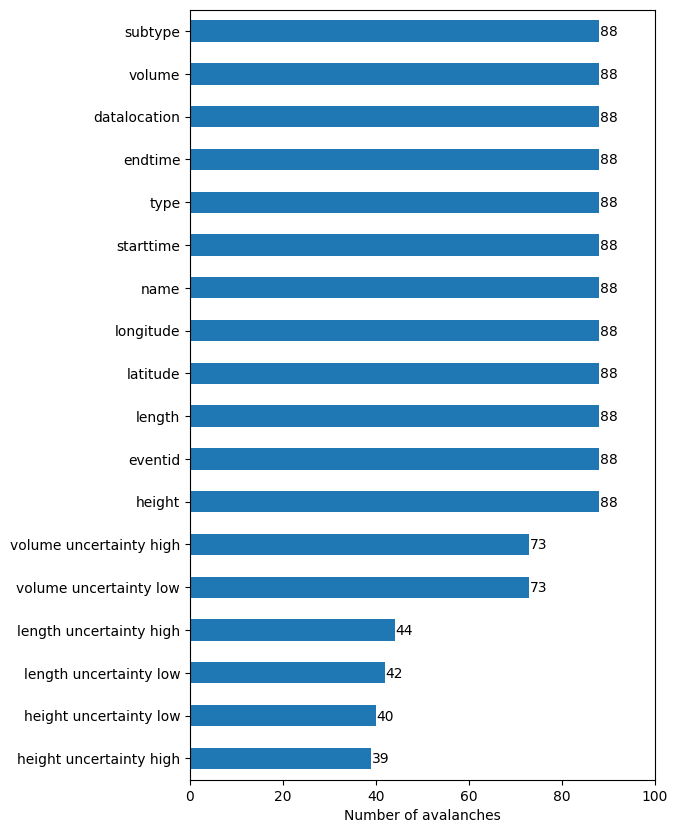

In [2]:
ESEC_avalanches = catalog.load("catalog/2_ESEC_avalanches_88.pickle")

catalog.open_plot(ESEC_avalanches, pos_number=0.11, xlim=100)

## Compute the height/length ratio

To fill in the missing uncertainties, we will use the height/length ratio (H/L) to simultaneously compute the uncertainties of length and height.

After computing the ratio, their uncertainties will be computed with this equation :

$$ \text{H/L\_err} = \frac{H}{L} \times \sqrt{ \left( \frac{\text{height uncertainty high} - \text{height uncertainty low}}{\text{height}} \right)^2 + \left( \frac{\text{length uncertainty high} - \text{length uncertainty low}}{\text{length}} \right)^2 } $$

The first part of this equation is the H/L ratio. The second part is the relative error.

If the H/L ratio is multiplied by the relative error, it is possible to obtain the absolute error.

In [3]:
## Compute H/L ratio
ESEC_avalanches['H/L'] = ESEC_avalanches['height'] / ESEC_avalanches['length']

## Add uncertainties on the H/L ratio from uncertainties of height and length
ESEC_avalanches['H/L_err'] = ESEC_avalanches['H/L'] * np.sqrt(((ESEC_avalanches["height uncertainty high"] - ESEC_avalanches['height uncertainty low']) / ESEC_avalanches['height'])**2 + ((ESEC_avalanches["length uncertainty high"] - ESEC_avalanches['length uncertainty low']) / ESEC_avalanches['length'])**2)

### 1. Remove outliers

In [4]:
## Compute the uncertainties
ESEC_avalanches['volume uncertainty'] = (ESEC_avalanches['volume uncertainty high'] - ESEC_avalanches['volume uncertainty low'])
ESEC_avalanches['height uncertainty'] = (ESEC_avalanches['height uncertainty high'] - ESEC_avalanches['height uncertainty low'])
ESEC_avalanches['length uncertainty'] = (ESEC_avalanches['length uncertainty high'] - ESEC_avalanches['length uncertainty low'])

## We look at the number of missing values ​​to fill in
print(ESEC_avalanches[['volume', 'volume uncertainty', 'height uncertainty', 'length uncertainty']].isnull().sum())

volume                 0
volume uncertainty    15
height uncertainty    49
length uncertainty    46
dtype: int64


In [5]:
## Removes outliers from the ESEC based on the interquartile range method.
ESEC_avalanches_without_NaN_in_volume = cp.remove_outliers_in_catalog(ESEC_avalanches, ESEC_avalanches['volume uncertainty'], ['volume', 'volume uncertainty'])
ESEC_avalanches_without_NaN_in_length = cp.remove_outliers_in_catalog(ESEC_avalanches, ESEC_avalanches['length uncertainty'], ['length', 'length uncertainty'])
ESEC_avalanches_without_NaN_in_height = cp.remove_outliers_in_catalog(ESEC_avalanches, ESEC_avalanches['height uncertainty'], ['height', 'height uncertainty'])

Lower bound for volume uncertainty: -7200000.0
Upper bound for volume uncertainty: 12192000.0
Number of outliers in volume uncertainty: 11
Lower bound for length uncertainty: -1600.0
Upper bound for length uncertainty: 3200.0
Number of outliers in length uncertainty: 2
Lower bound for height uncertainty: -50.0
Upper bound for height uncertainty: 350.0
Number of outliers in height uncertainty: 4


### 2. Plot models

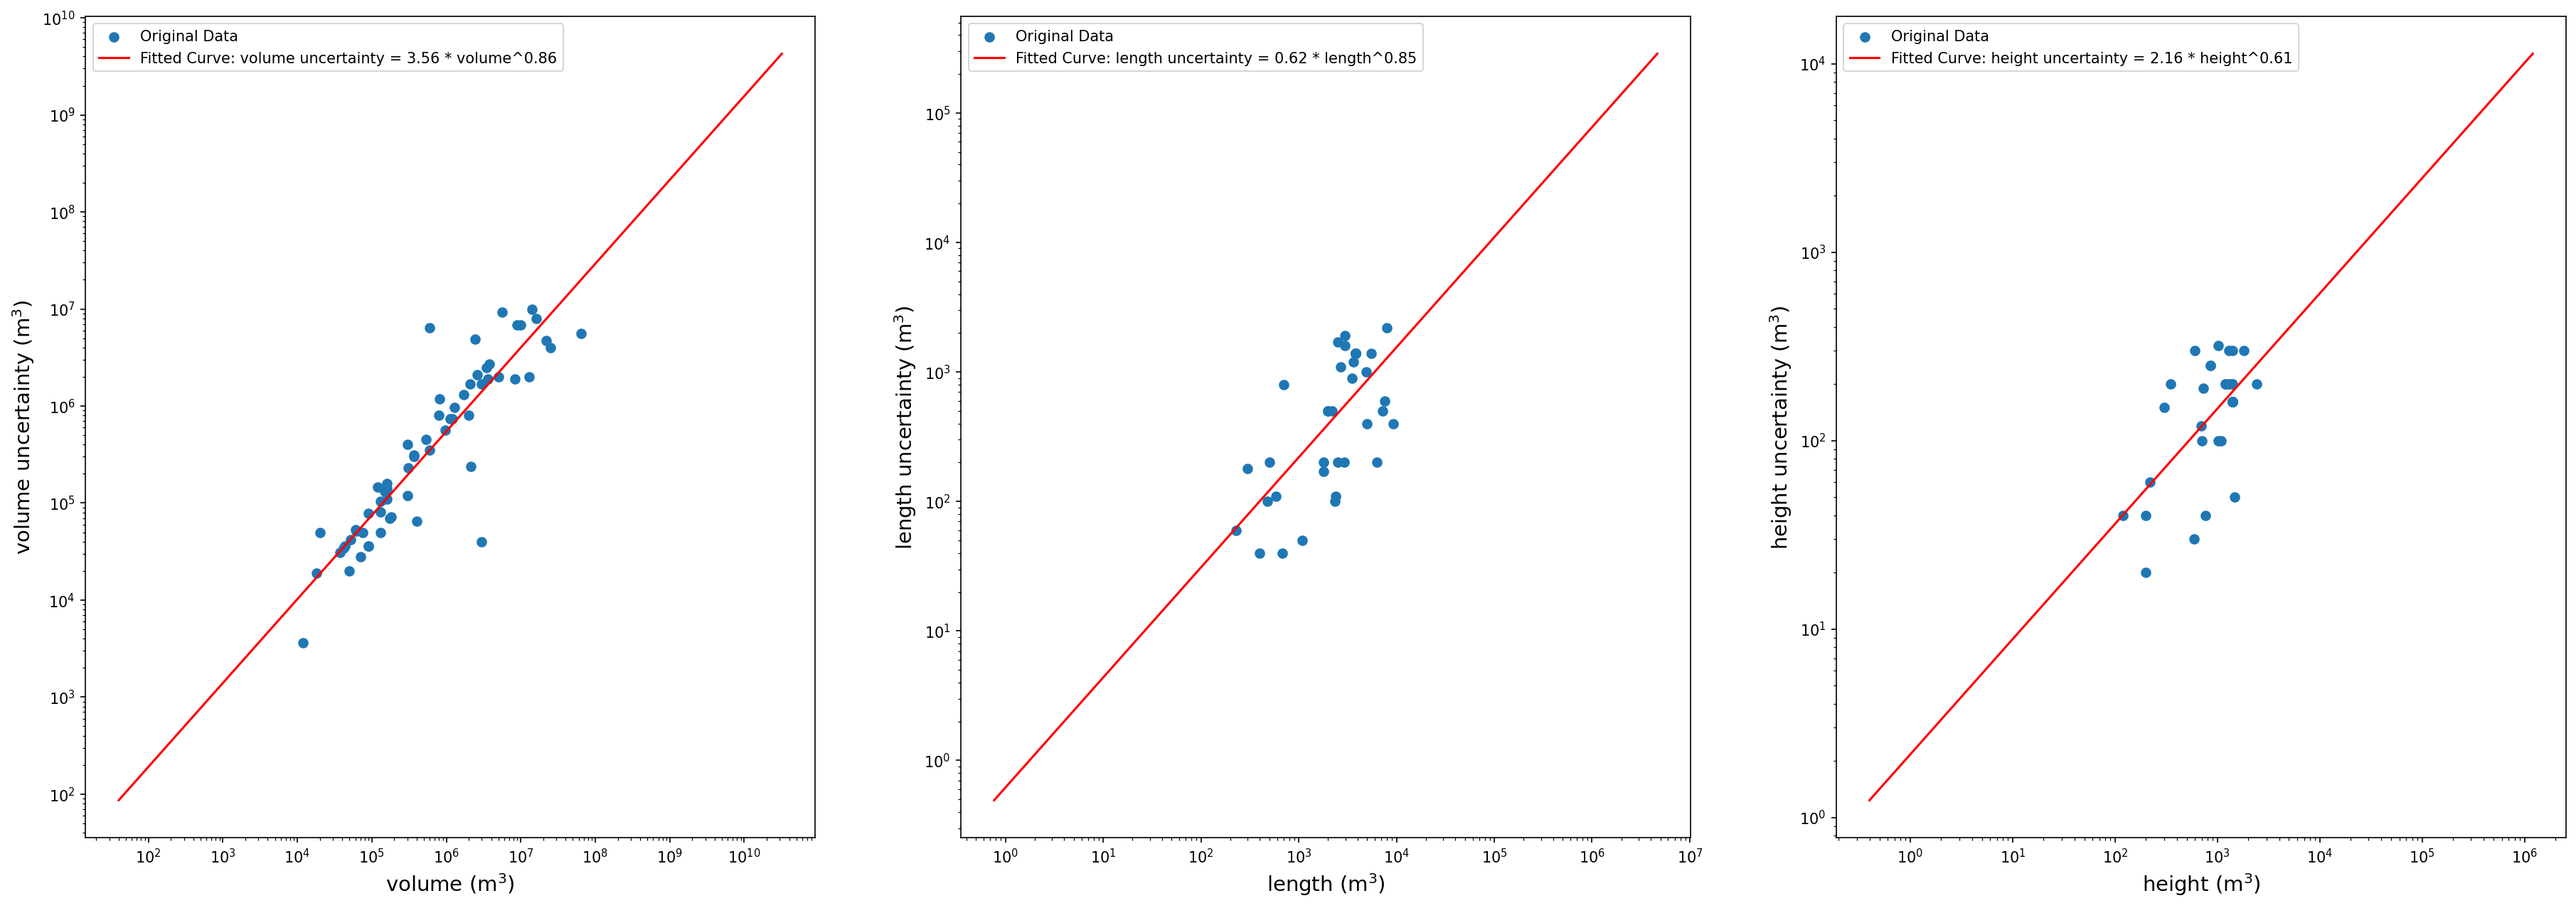

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), dpi=150)

log_volume, log_DV, volume_fit, DV_fit, popt_DV, pcov_DV, a_DV, b_DV = figures.plot_fitted_curve(ESEC_avalanches_without_NaN_in_volume, "volume", "volume uncertainty", ax, 0)
log_length, log_Dl, length_fit, Dl_fit, popt_Dl, pcov_Dl, a_Dl, b_Dl = figures.plot_fitted_curve(ESEC_avalanches_without_NaN_in_length, "length", "length uncertainty", ax, 1)
log_height, log_Dh, height_fit, Dh_fit, popt_Dh, pcov_Dh, a_Dh, b_Dh = figures.plot_fitted_curve(ESEC_avalanches_without_NaN_in_height, "height", "height uncertainty", ax, 2)

### 3. Compute confidence intervals

In [7]:
DV_fit_lower, DV_fit_upper = cp.confidence_bounds(volume_fit, log_volume, popt_DV, pcov_DV)
Dl_fit_lower, Dl_fit_upper = cp.confidence_bounds(length_fit, log_length, popt_Dl, pcov_Dl)
Dh_fit_lower, Dh_fit_upper = cp.confidence_bounds(height_fit, log_height, popt_Dh, pcov_Dh)

In [8]:
## Keep events that have no uncertainties
ESEC_avalanches_volume_without_incertainties = ESEC_avalanches[~(ESEC_avalanches['volume uncertainty high'].notna() & ESEC_avalanches['volume uncertainty low'].notna())]
ESEC_avalanches_height_without_incertainties = ESEC_avalanches[~(ESEC_avalanches['height uncertainty high'].notna() & ESEC_avalanches['height uncertainty low'].notna())]
ESEC_avalanches_length_without_incertainties = ESEC_avalanches[~(ESEC_avalanches['length uncertainty high'].notna() & ESEC_avalanches['length uncertainty low'].notna())]

## Compute the corresponding y values on the curve for each values
DV = a_DV * ESEC_avalanches_volume_without_incertainties['volume'] ** b_DV
Dh = a_Dh * ESEC_avalanches_height_without_incertainties['height'] ** b_Dh
Dl = a_Dl * ESEC_avalanches_length_without_incertainties['length'] ** b_Dl

### 4. Plot fitted models with confidence intervals

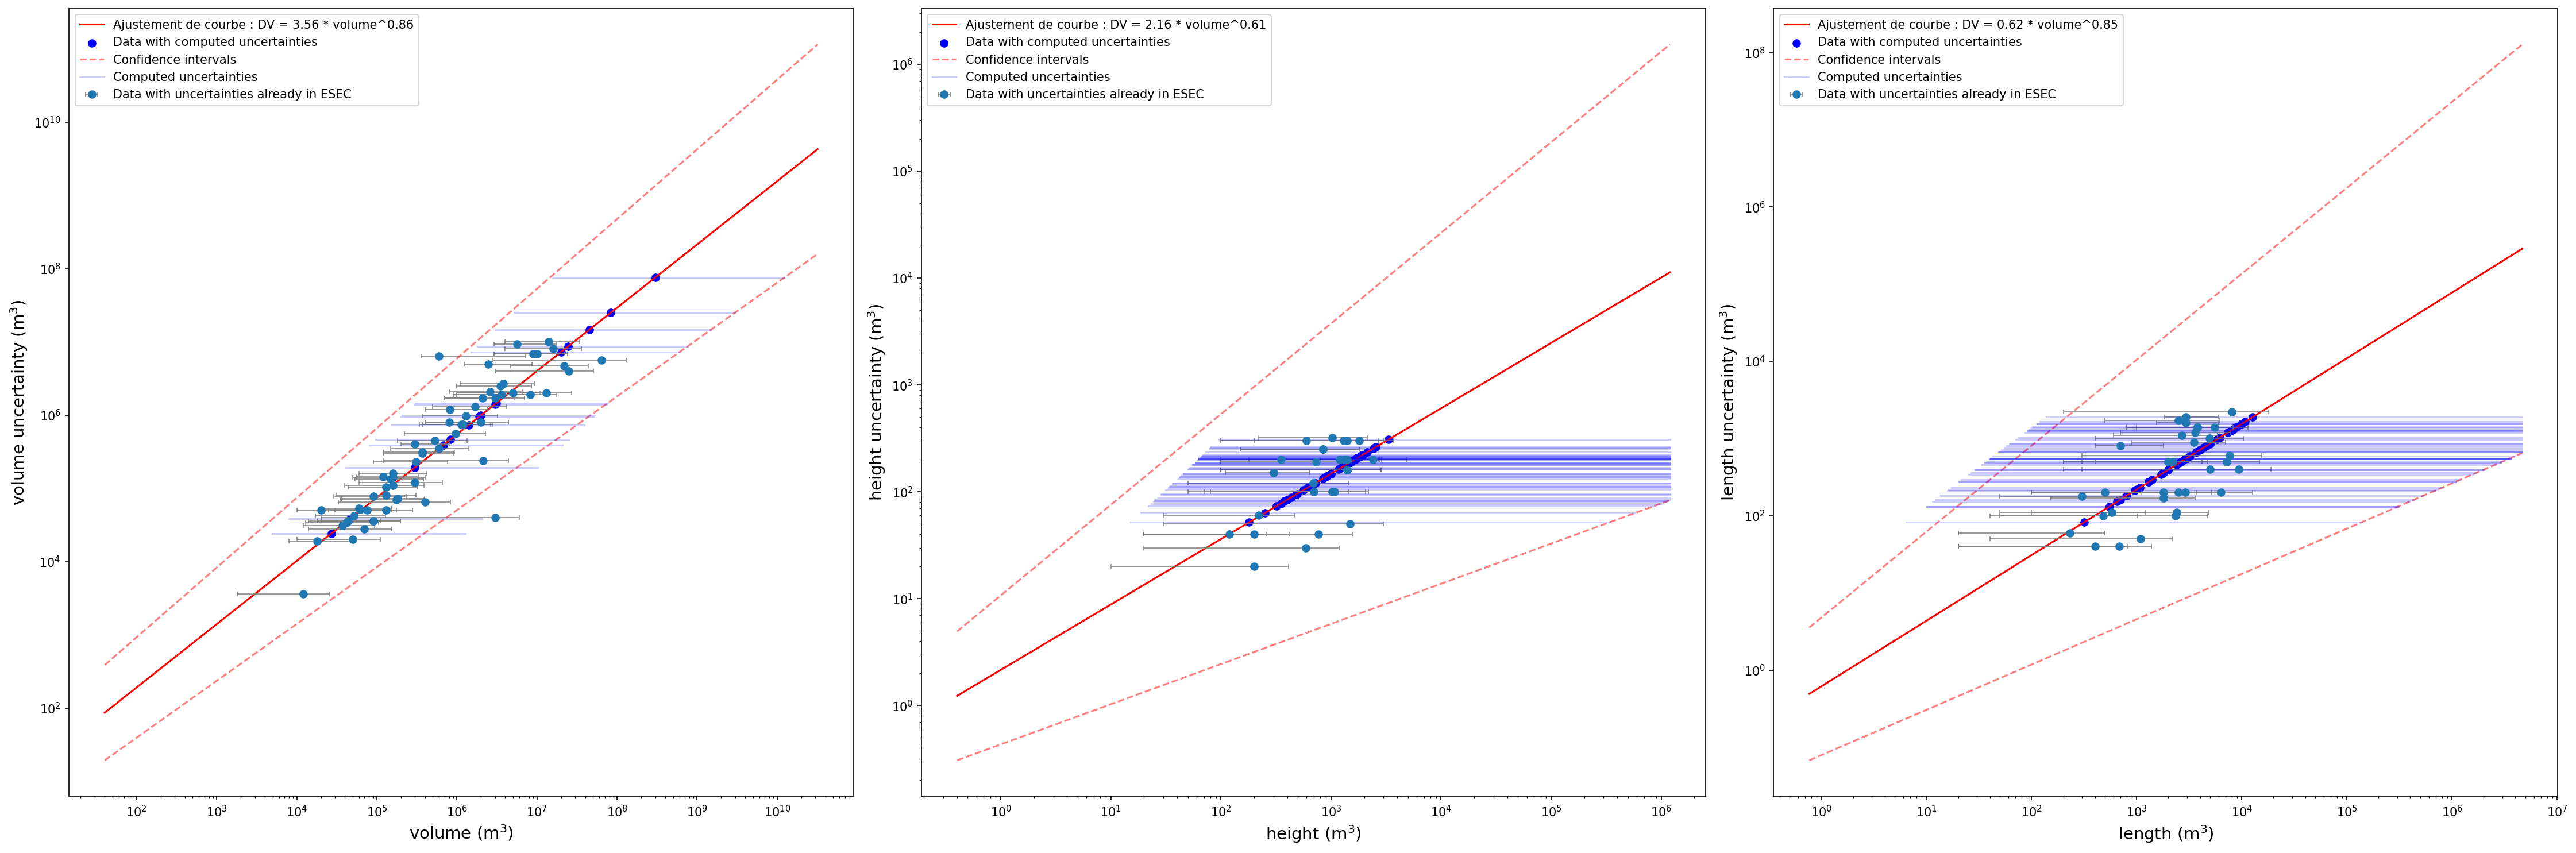

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), dpi=150)

ESEC_avalanches_with_incertainties = figures.plot_fitted_curve_without_incertainties(ESEC_avalanches, ESEC_avalanches_volume_without_incertainties, ESEC_avalanches_without_NaN_in_volume, volume_fit, DV_fit, DV_fit_lower, DV_fit_upper, DV, a_DV, b_DV, "volume", "volume uncertainty", "volume uncertainty low", "volume uncertainty high", ax, 0)
ESEC_avalanches_with_incertainties = figures.plot_fitted_curve_without_incertainties(ESEC_avalanches_with_incertainties, ESEC_avalanches_height_without_incertainties, ESEC_avalanches_without_NaN_in_height, height_fit, Dh_fit, Dh_fit_lower, Dh_fit_upper, Dh, a_Dh, b_Dh, "height", "height uncertainty", "height uncertainty low", "height uncertainty high", ax, 1)
ESEC_avalanches_with_incertainties = figures.plot_fitted_curve_without_incertainties(ESEC_avalanches_with_incertainties, ESEC_avalanches_length_without_incertainties, ESEC_avalanches_without_NaN_in_length, length_fit, Dl_fit, Dl_fit_lower, Dl_fit_upper, Dl, a_Dl, b_Dl, "length", "length uncertainty", "length uncertainty low", "length uncertainty high", ax, 2)

figures.save("figures/incertainties.pdf")

## Remove useless columns 

In [10]:
ESEC_avalanches_with_incertainties = ESEC_avalanches_with_incertainties.drop(columns=['volume uncertainty'])
ESEC_avalanches_with_incertainties = ESEC_avalanches_with_incertainties.drop(columns=['length uncertainty'])
ESEC_avalanches_with_incertainties = ESEC_avalanches_with_incertainties.drop(columns=['height uncertainty'])

## Remove NaN in columns

In [11]:
## In "determined_uncertainty", "True" means that the uncertainties have been computed here. "False" means that the uncertainties were already given in the catalog.
ESEC_avalanches_with_incertainties["determined_uncertainty"].fillna(False, inplace=True)

## Fill in missing uncertainties in "H/L_err"
ESEC_avalanches_with_incertainties['H/L_err'] = ESEC_avalanches['H/L'] * np.sqrt(((ESEC_avalanches["height uncertainty high"] - ESEC_avalanches['height uncertainty low'])/ESEC_avalanches['height'])**2 + ((ESEC_avalanches["length uncertainty high"] - ESEC_avalanches['length uncertainty low'])/ESEC_avalanches['length'])**2)

C:\Users\Thibaut\AppData\Local\Temp\ipykernel_12128\1651426216.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ESEC_avalanches_with_incertainties["determined_uncertainty"].fillna(False, inplace=True)


## Now, all columns are filled

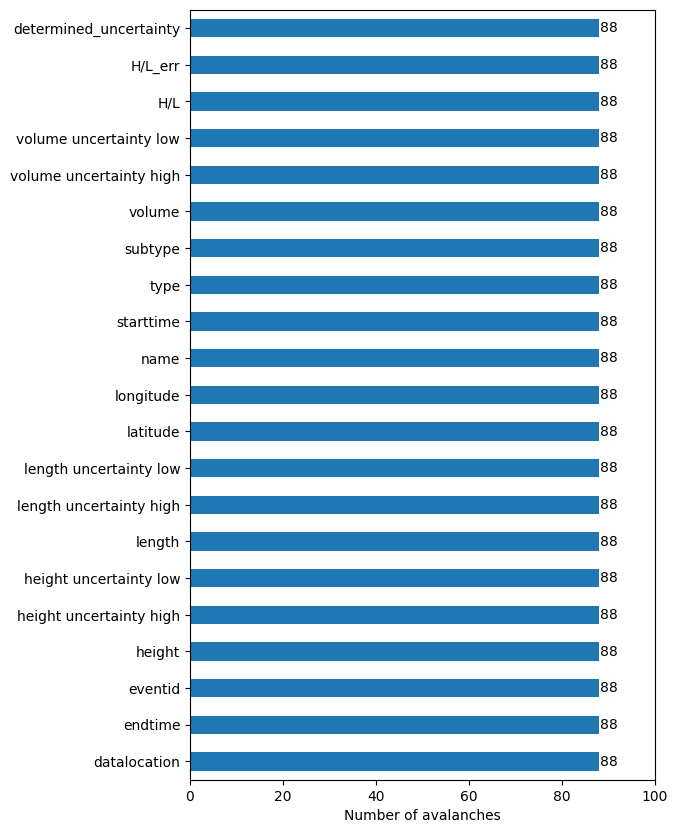

In [12]:
catalog.open_plot(ESEC_avalanches_with_incertainties, 0.11)

ESEC_avalanches_with_incertainties.to_pickle("catalog/3_ESEC_avalanches_88.pickle")